In [ ]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from options import *
from constants import *
import tifffile

# légerement mieux que plt (mais c'est basé sur plt bien sur) et permet de rajouter une scalebar 
# import microfilm.microplot as microplt


nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [17]:
p = plt.rcParams
p['axes.grid'] = False
p['xtick.bottom'] = False
p['xtick.labelbottom'] = False
p['ytick.left'] = False
p['ytick.labelleft'] = False

In [ ]:
# id,frame,x [nm],y [nm],sigma [nm],intensity [photon],amplitude [photon],offset [photon],bkgstd [photon],uncertainty_xy [nm]
id, frame, x, y, sigma, intensity, amplitude, offset, bkgstd, uncertainty_xy = np.loadtxt("../data/microtubules/Acquisition-5/CoordTable_SAFE180_2D.csv",
                                                                                          unpack=True, delimiter=',', skiprows=1)

Interesting: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density

Ou sinon on utilise le TIFF

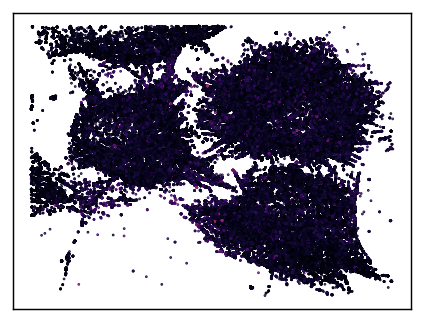

In [19]:
plt.scatter(x,y, marker='.', s=1,
            c=intensity, cmap='inferno')
plt.show()

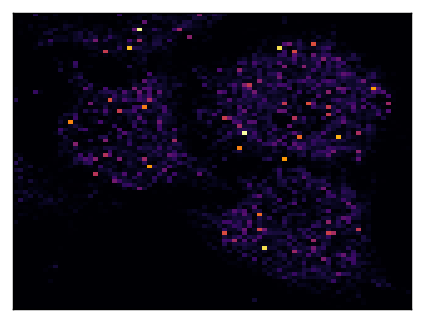

In [20]:
plt.hist2d(x,y, bins=80, cmap='inferno')
plt.show()

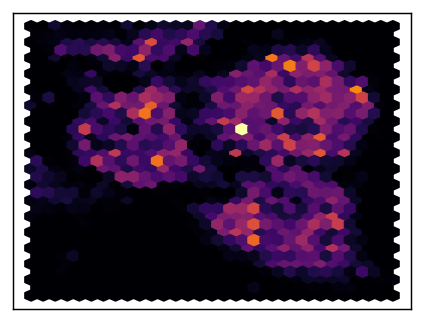

In [21]:
plt.hexbin(x,y, gridsize=30, cmap='inferno')
plt.show()

In [22]:
imdata = tifffile.imread('../data/microtubules/Acquisition-5/NANO2D_pix_15nm.tif')
pix_min = np.min(imdata)
pix_max = np.max(imdata)
normalized_imdata = (imdata - pix_min) / (pix_max - pix_min)
print(np.mean(normalized_imdata))
# print(pix_min)
print(pix_max)
# print(np.max(normalized_imdata))
np.sum(normalized_imdata > 0.01)



0.00013943184
8552.698


np.int64(83818)

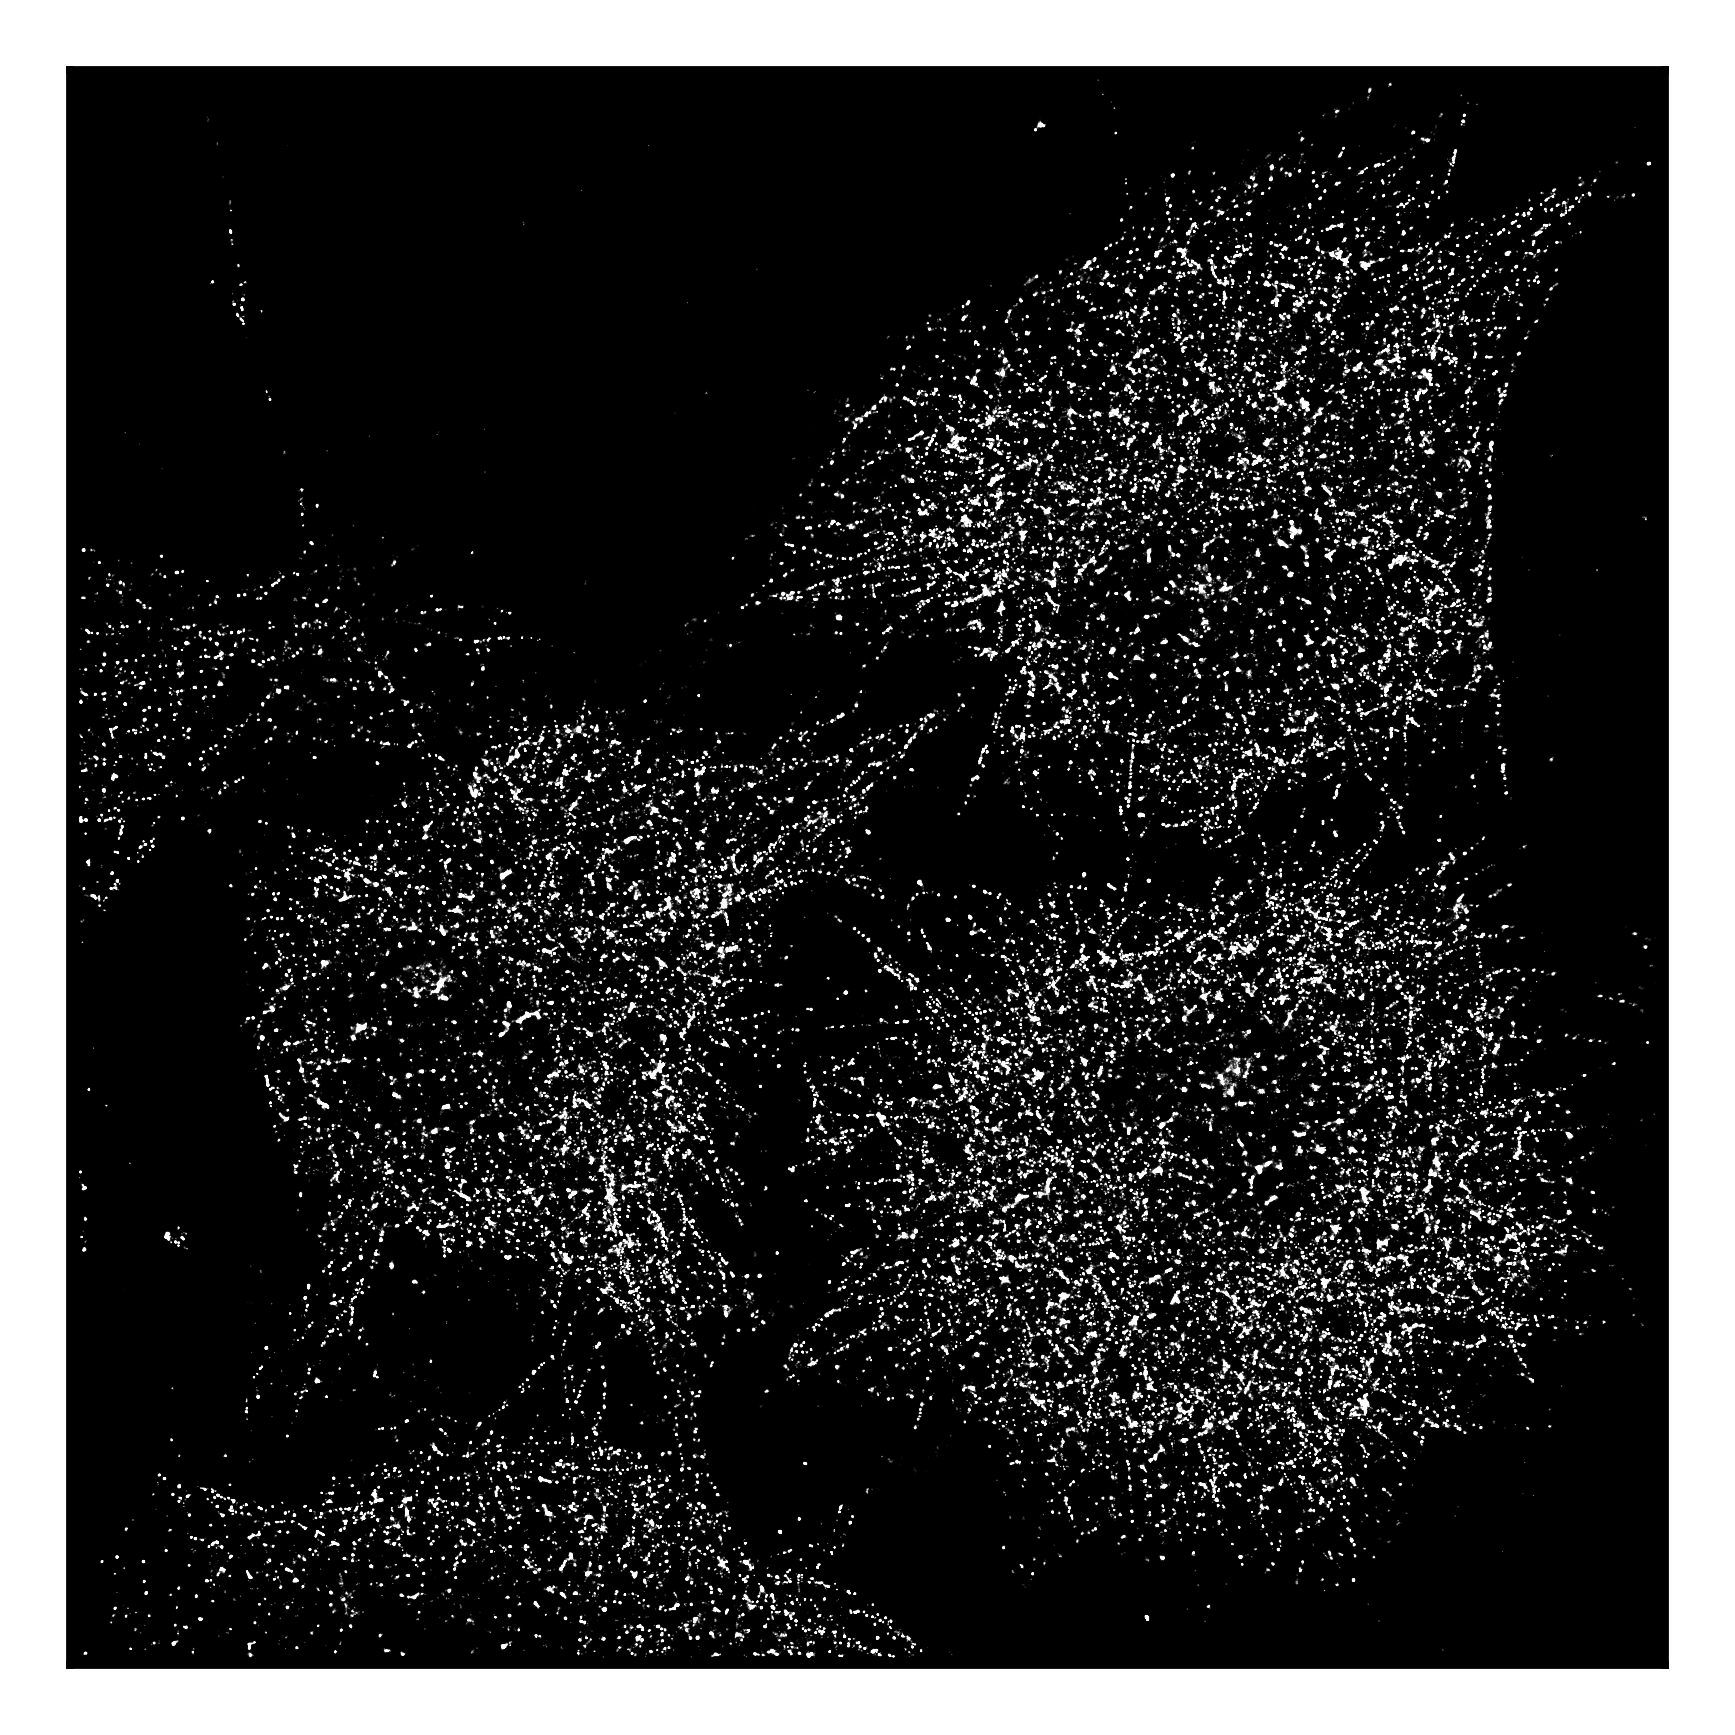

In [27]:
plt.figure(dpi=700)
plt.imshow(normalized_imdata, cmap=plt.get_cmap('Greys_r'),
           vmax=0.0007)
# plt.colorbar()
plt.savefig("../figures/test.pdf")
plt.show()


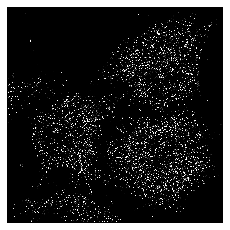

In [ ]:
# microim = microplt.microshow(normalized_imdata, limits=[0,0.0007])
# microplt.savefig("../figures/micro.pdf", dpi=700)
